# Transitioning to autonomous driving: <br>Mixed vehicle autonomy levels on freeways
### Notebook to provide data analysis on the performed simulations.

Jesse Poland<br>
TU Delft<br>
Date: 02-10-2024<br>

### 0. Python packages and loading data files

First, Python packages are imported to provide specific functionalities within the notebook. Then, the file paths are set to retrieve stored simulation data for all experiment runs and seeds. The simulation data is loaded into Pandas DataFrames, making the data ready for analysis.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from IPython.display import display

In [2]:
# simulation output folder
# experiment_name = 'full_level_runs_1'
experiment_name = 'test_data'

# load Java simulation data
experiment_folder = fr'C:\Users\jesse\Documents\Java\TrafficSimulation-workspace\traffic-sim\src\main\resources\{experiment_name}'

# available files
input_values = 'inputValues.csv'
intermediate_output = 'intermediateOutputData.csv'
single_output = 'singleOutputData.csv'
sequence_output = 'sequenceOutputData.csv'
lane_change_output = 'laneChangeOutputData.csv'

In [3]:
# function to get a list of all file/folder names within a folder
def get_file_names(path):
    return os.listdir(path)

# load available seed folders
seed_folders = get_file_names(experiment_folder)

In [4]:
# function to retrieve any data within the project folder as dataframe
def load_dataframe(columns_of_interest, folder, file, input_file=None):
    # create empty DataFrame
    df = pd.DataFrame()
    
    # loop through all seed folders from this experiment
    for seed_name in get_file_names(folder):
        # get all runs within this experiment
        run_folders = get_file_names(os.path.join(folder, seed_name))
        
        # go through all runs
        for run_folder in run_folders:
            run_number = int(run_folder.split('_')[1])
            data_folder = os.path.join(folder, seed_name, run_folder)

            # open zip file (remove .csv form file name)
            try:
                with zipfile.ZipFile(os.path.join(data_folder, fr'{file[:-4]}.zip'), 'r') as zip_ref:
                    # read sequence csv
                    with zip_ref.open(file) as data_file:
                        df_run = pd.read_csv(data_file)
                        df_interest = df_run[columns_of_interest].copy()
                        df_interest['run'] = run_number
                # add input values to the dataframe if the input file is specified
                if input_file is not None:
                    # open input zip file
                    with zipfile.ZipFile(os.path.join(data_folder, fr'{input_file[:-4]}.zip'), 'r') as zip_ref:
                        # read input csv
                        with zip_ref.open(input_file) as input_data_file:
                            df_input = pd.read_csv(input_data_file)
                    # broadcast input data to all rows in df_interest
                    for col in df_input.columns:
                        df_interest[col] = df_input[col].iloc[0]

                # add this data to the main DataFrame
                df = pd.concat([df, df_interest])
            except:
                print(f'An error occured when trying to read data from: {data_folder}. This folder may contain a BadZipFile.')

    # return resulting DataFrame
    df.reset_index(drop=True, inplace=True)
    return df
    

### 1. Traffic performance

In [5]:
def show_fd_graph(df):
    # create figure
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    # group by vehicle penetration rate
    grouped_df = df.groupby(['level0_fraction', 'level1_fraction', 'level2_fraction', 'level3_fraction'])

    for name, group in grouped_df:
        df_group = grouped_df.get_group(name)
        df_group = df_group.reset_index()
        df_group = df_group.sort_values('mean_density')

        # split data for trend lines
        # mean_density_value = df_group['mean_density'].mean()
        max_flow_index = df_group['mean_flow'].idxmax()
        df_free_flow = df_group.loc[:max_flow_index]
        df_congested = df_group.loc[max_flow_index:]
        
        # df_free_flow = df_group[df_group['mean_density'] <= critical_density]
        # df_congested = df_group[df_group['mean_density'] > critical_density]
    
        # plot scatter group data
        scatter = ax.scatter(df_group['mean_density'], df_group['mean_flow'], label=name)
        color = scatter.get_facecolors()[0]
        color_t = color.copy()
        color_t[3] = 0.25
        scatter.set_facecolors(color_t)

        # add trend lines for first and second half of plot
        # add_trend_line(ax, df_x=df_group['mean_density'], df_y=df_group['mean_flow'], degree=2,
        #                line_type="-", line_color=color, name='Trend line')
        add_trend_line(ax, df_free_flow['mean_density'], df_free_flow['mean_flow'], degree=1, line_type='--', line_color=color, name='Free-flow trend')
        add_trend_line(ax, df_congested['mean_density'], df_congested['mean_flow'], degree=1, line_type='-.', line_color=color, name='Congested trend')

    # show plot
    ax.set_title('Density vs Flow')
    ax.set(xlabel='Density (veh/km)', ylabel='Flow (veh/h)')
    ax.spines[['right', 'top']].set_visible(False)
    ax.legend()
    plt.show()


# function to add a trend line
def add_trend_line(ax, df_x, df_y, degree, line_type, line_color, name):
    # fit a polynomial trendline to data
    z = np.polyfit(df_x, df_y, degree)
    p = np.poly1d(z)
    # generate x and y values for the trend line
    x_fit = np.linspace(df_x.min(), df_x.max(), 100)
    y_fit = p(x_fit)
    # plot trend line
    ax.plot(x_fit, y_fit, line_type, color=line_color, label=f'{degree}-degree {name}')


In [6]:
df_single_fd = load_dataframe(['mean_speed', 'mean_density', 'mean_flow'], experiment_folder, single_output, input_values)

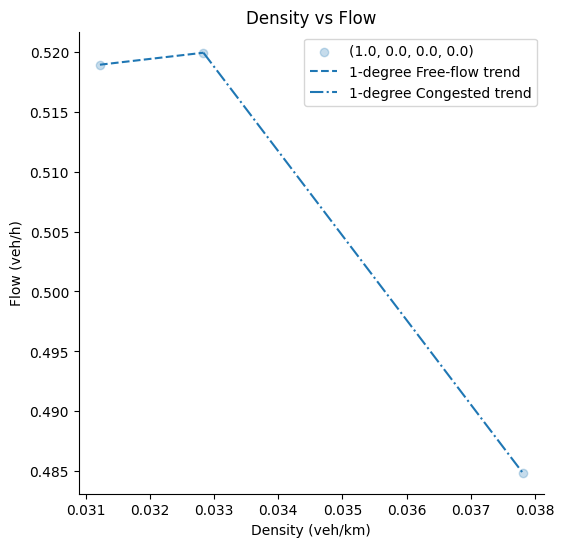

In [7]:
show_fd_graph(df_single_fd)

In [8]:
# function to compare mean values
def compare_speed_values(df):
    # group by vehicle penetration rate
    grouped_df = df.groupby(['level0_fraction', 'level1_fraction', 'level2_fraction', 'level3_fraction'])
    group_order = sorted(grouped_df.groups.keys(), key=lambda x: (x[0], x[1], x[2], x[3]), reverse=True)
    
    # show boxplots for speed
    variables = ['speed',]
    for variable in variables:
        fig, ax = plt.subplots(figsize=(10, 6))
        box_data = []
        box_labels = []
    
        # loop through each group and collect data for the current variable
        for name in group_order:
            group = grouped_df.get_group(name)
            box_data.append(group[variable].values)
            box_labels.append(f'{name}')
        
        # create boxplot
        ax.boxplot(box_data, tick_labels=box_labels)
        ax.set_title(f'Boxplot for {variable} across penetration rate')
        ax.set_xlabel('Vehicle penetration rate (level0, level1, level2, level3)')
        ax.set_ylabel(variable)
            
        # display boxplot
        plt.tight_layout()
        plt.show()


In [9]:
# get sequence data
df_sequence = load_dataframe(['time', 'gtu_id', 'gtu_type', 'speed'], experiment_folder, sequence_output, input_values)

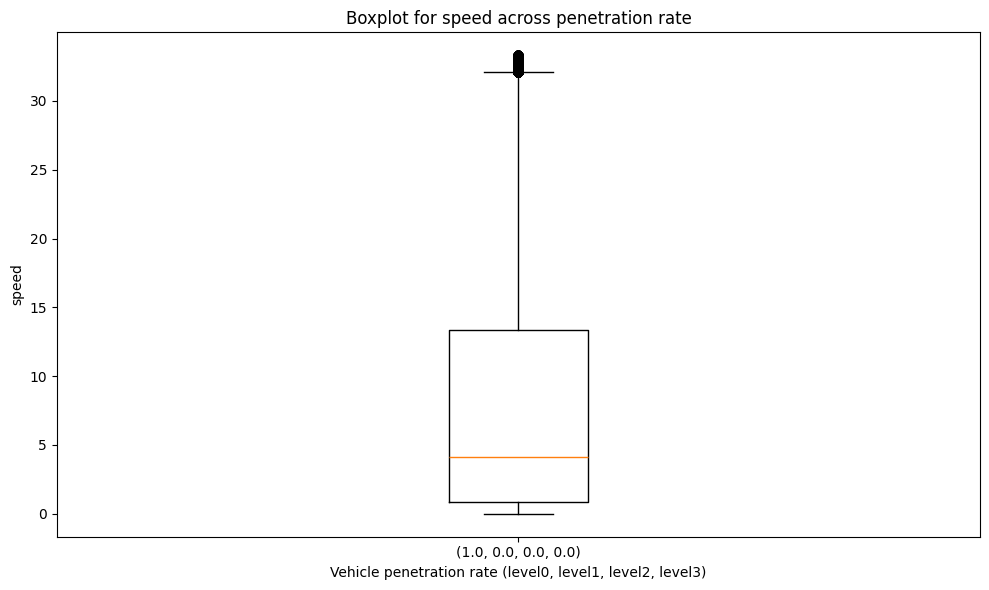

In [10]:
# compare values
compare_speed_values(df_sequence)

In [11]:
# function to compare mean values
def compare_travel_time_values(df):
    # we only need travel time, and this column has NaN values because there are less vehicles
    # in a simulation than time steps. Time steps and travel time is not linked
    df = df.dropna()
    
    # group by vehicle penetration rate
    grouped_df = df.groupby(['level0_fraction', 'level1_fraction', 'level2_fraction', 'level3_fraction'])
    group_order = sorted(grouped_df.groups.keys(), key=lambda x: (x[0], x[1], x[2], x[3]), reverse=True)
    
    # show boxplots for speed
    variables = ['mean_travel_time',]
    for variable in variables:
        fig, ax = plt.subplots(figsize=(10, 6))
        box_data = []
        box_labels = []
    
        # loop through each group and collect data for the current variable
        for name in group_order:
            group = grouped_df.get_group(name)
            box_data.append(group[variable].values)
            box_labels.append(f'{name}')
        
        # create boxplot
        ax.boxplot(box_data, tick_labels=box_labels)
        ax.set_title(f'Boxplot for {variable} across penetration rate')
        ax.set_xlabel('Vehicle penetration rate (level0, level1, level2, level3)')
        ax.set_ylabel(f'{variable} [s]')
            
        # display boxplot
        plt.tight_layout()
        plt.show()



In [12]:
# get intermediate data
df_travel_time = load_dataframe(['mean_travel_time'], experiment_folder, intermediate_output, input_values)

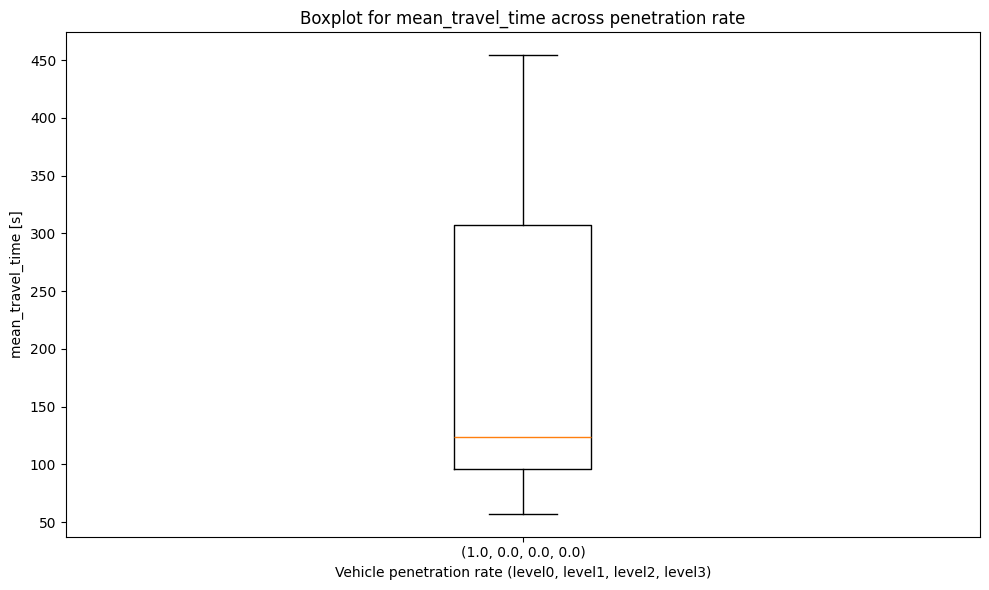

In [13]:
# compare values
compare_travel_time_values(df_travel_time)

### 2. Traffic safety

In [28]:
def percentage_critical_ttc(df):
    penetration_columns = ['level0_fraction', 'level1_fraction', 'level2_fraction', 'level3_fraction']
    required_columns = ['time', 'ttc', 'reaction_time']
    df_required = df[penetration_columns + required_columns]

    # groupby penetration rates
    grouped_df = df_required.groupby(['level0_fraction', 'level1_fraction', 'level2_fraction', 'level3_fraction'])
    group_order = sorted(grouped_df.groups.keys(), key=lambda x: (x[0], x[1], x[2], x[3]), reverse=True)

    # show boxplots
    fig, ax = plt.subplots(figsize=(10, 6))
    box_data = []
    box_labels = []
    
    # loop through each group and collect data for acceleration
    for name in group_order:
        group = grouped_df.get_group(name)
        # create critical ttc column
        group['critical_ttc'] = group['ttc'] < 0.8
        # aggregate dataframe by time
        df_count_by_time = group.groupby('time').agg({'critical_ttc': ['sum', 'count'],}).reset_index()
        # flatten the multi-level columns
        df_count_by_time.columns = ['time', 'true_count', 'total_count']
        # calculate percentage
        df_percentage = df_count_by_time.copy()
        df_percentage['percentage_critical_ttc'] = df_percentage['true_count'] / df_percentage['total_count'] * 100

        # add to boxplot data
        box_data.append(df_percentage['percentage_critical_ttc'].values)
        box_labels.append(f'{name}')

    # create boxplot
    ax.boxplot(box_data, tick_labels=box_labels)
    ax.set_title(f'Boxplot for percentage critical TTCs across penetration rates')
    ax.set_xlabel('Vehicle penetration rate (level0, level1, level2, level3)')
    ax.set_ylabel('Percentage of critical TTCs')
        
    # display boxplot
    plt.tight_layout()
    plt.show()



In [25]:
df_safety = load_dataframe(['time', 'gtu_id', 'gtu_type', 'ttc', 'reaction_time'], experiment_folder, sequence_output, input_values)

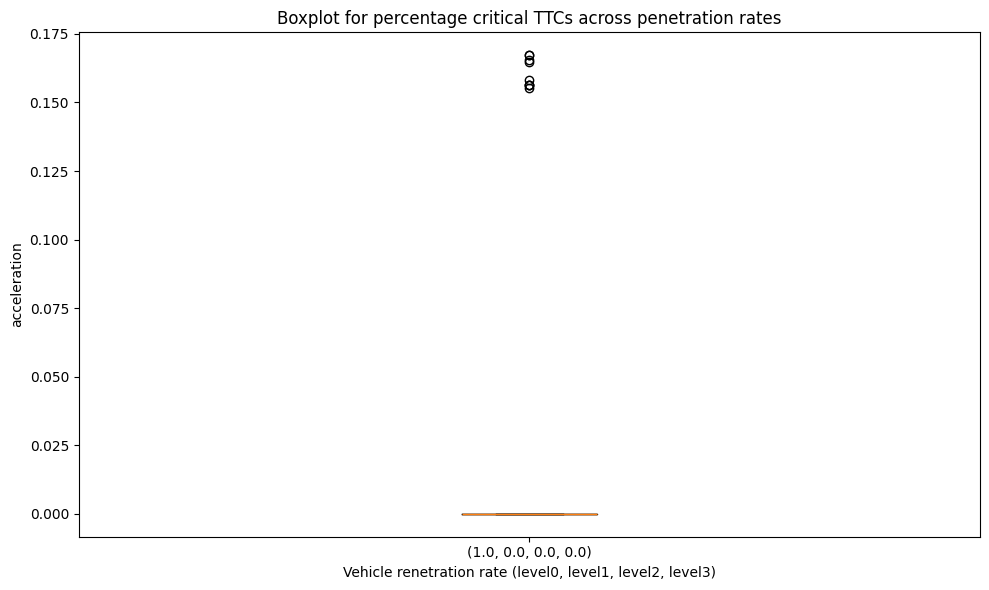

In [29]:
percentage_critical_ttc(df_safety)